# Configuration and download of the dataset




In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%ls drive/My\ Drive/ColabFiles
%cd drive/My\ Drive/ColabFiles/FacebookAI



'aaron scraper.ova'   hatefulmemes-2020-07-23_12.17.07.mp4
 FacebookAI/          options.ini
/content/drive/My Drive/ColabFiles/FacebookAI


# Loading dataset files, texts and labels into dataset dictionary

In [ ]:
import json
train_json = open('./data/train.jsonl','r').readlines()
test_json = open('./data/test_unseen.jsonl','r').readlines()
dev_json = open('./data/dev_unseen.jsonl','r').readlines() + open('./data/dev_seen.jsonl','r').readlines()

print(*train_json[:2], sep='\n')



{"id":42953,"img":"img\/42953.png","label":0,"text":"its their character not their color that matters"}

{"id":23058,"img":"img\/23058.png","label":0,"text":"don't be afraid to love again everyone is not like your ex"}



In [ ]:
%ls -la

total 20365646
-rw------- 1 root root      224297 Oct  6 11:48 000000000009.jpg
-rw------- 1 root root      685628 Jun  9 19:18 10000.txt
drwx------ 2 root root        4096 Oct 27 15:37 annotations/
drwx------ 2 root root        4096 Oct 28 10:46 checkpoints/
drwx------ 2 root root        4096 Oct 24 15:57 data/
-rw------- 1 root root      844181 Oct 29 22:20 dataset_captions.txt
-rw------- 1 root root       55143 May 12 15:20 dev.jsonl
-rw------- 1 root root  4227357188 Oct 24 14:40 fb.zip
-rw------- 1 root root   347116733 Aug  4  2014 glove.6B.100d.txt
-rw------- 1 root root   693432828 Aug  4  2014 glove.6B.200d.txt
-rw------- 1 root root  1037962819 Aug 27  2014 glove.6B.300d.txt
-rw------- 1 root root   171350079 Aug  4  2014 glove.6B.50d.txt
-rw------- 1 root root   862182613 Oct 25  2015 glove.6B.zip
-rw------- 1 root root     2546446 Oct 24 19:14 labeled_data.csv
-rw------- 1 root root        9867 May 12 15:20 LICENSE.txt
drwx------ 2 root root        4096 Jun 19 15:15 models/

In [ ]:
f = open('dataset_captions.txt','r')

captions = f.readlines()
print(captions)
captions = list(map(lambda x: x.split('::'), captions))

dict_captions = {}
for caption in captions:
  if len(caption) < 2:
    dict_captions[caption[0].replace('\n','')] = ''
  else:
    dict_captions[caption[1].replace('\n','')] = caption[0]
print(dict_captions)


['a person holds a brown donut on a banana in the dark::img/87692.png\n', 'a man in a suit and tie with juice::img/84325.png\n', 'a girl wearing a leopard scarf looking at her phone::img/42083.png\n', 'a black and white photograph of a boy standing in a tie::img/26531.png\n', 'this photograph of a boy wearing a <unk> shirt and white shirt::img/87390.png\n', 'a skateboarder is dressed in wearing a person performs a lighted snow board and one holding animal glove::img/10475.png\n', 'a woman with <unk> a drink::img/91736.png\n', 'an image of a man holding a female tennis player about to his nose next to a cell phone::img/48379.png\n', 'a man sitting on a dumpster eating food and a hello kitty::img/19740.png\n', 'a woman wearing a chair while laying on a short pink blanket that lies down::img/21659.png\n', 'male and girl is talking in a senior <unk> and next to a pair of scissors::img/19846.png\n', 'person holding up silver scissors::img/16758.png\n', 'smiling <unk> in the car while holdin

In [ ]:
len(dict_captions.keys())

11175

In [ ]:
# get the set of words in all labels
def create_text(line):
  text = json.loads(line)['text']
  filepath = json.loads(line)['img']
  try:
    t = dict_captions[filepath] +'. '+ text 
  except:
    t = text + ' #'
  return t

train_dataset = {
    'files_path': [json.loads(line)['img'] for line in train_json],
    'text': [create_text(line) for line in train_json],
    'label' : [json.loads(line)['label'] for line in train_json],
    'caption' : None
}

dev_dataset = {
    'files_path': [json.loads(line)['img'] for line in dev_json],
    'text': [create_text(line) for line in dev_json],
    'label' : [json.loads(line)['label'] for line in dev_json],
     'caption' : None
}

test_dataset = {
    'files_path': [json.loads(line)['img'] for line in test_json],
    'text': [create_text(line) for line in test_json],
    'id':[json.loads(line)['id'] for line in test_json], 
    'caption' : None
}
 
print(f'Training: {len(train_dataset["text"])}, Dev: {len(dev_dataset["text"])}, Test: {len(test_dataset["text"])}')


Training: 8500, Dev: 1040, Test: 2000


In [ ]:
dev_dataset['text']

a man and a guy takes a pirate with a mans tie. when the deaf kid insults you with sign language, so you break his fingers modern problems require modern solutions
./data/img/79832.png


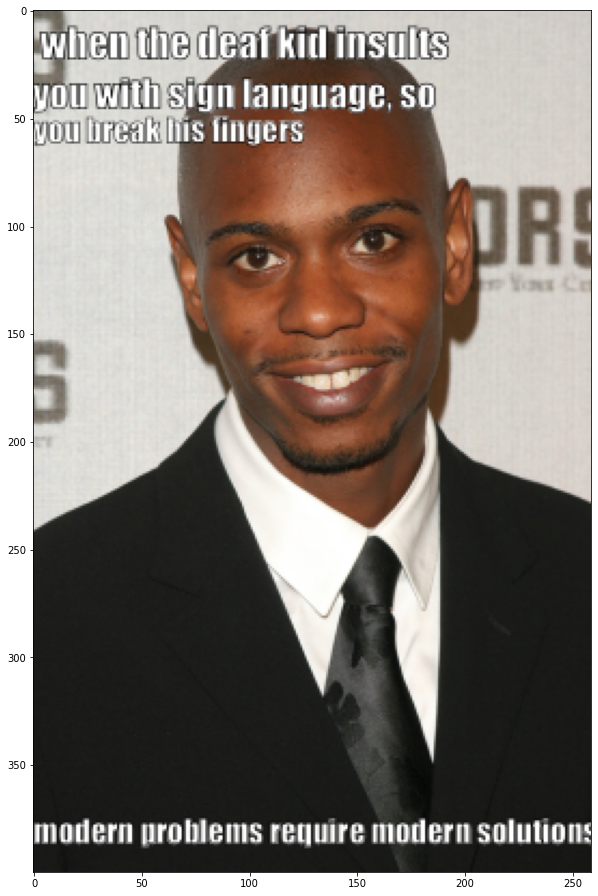

In [ ]:
import random
cnt = random.randrange(1,6000)
print(train_dataset['text'][cnt])
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filepath ='./data/'+ train_dataset['files_path'][cnt]
img = mpimg.imread(filepath)

# plt.plot(train_dataset[''])
print(filepath)
from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
# plt.RcParams['figsize'] = (14, 7)
plt.imshow(img)
plt.show()


In [ ]:
# def write_files_paths_relative(paths):
#   paths = list(map(lambda x:'../../../'+x, paths))
#   f = open('./pretrained_image_captioning/examples/noc/FBAIimages.txt','w')
#   f.write('\n'.join(paths))
# all_files_paths = train_dataset['files_path'] + dev_dataset['files_path'] + test_dataset['files_path']
# write_files_paths_relative(all_files_paths)

# NLP starts

## Code


In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


vocab_size = 10000

embedding_dim = 200 # maybe 200 is the best

max_length = 40
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8
training_thresh = 8500
dev_thresh = 8500 + 1040
batch_size = 256
rnn_units = 256
hatespeech_thresh = 10000

In [ ]:
len(dev_json)

1040

In [ ]:
%ls -la

total 20365620
-rw------- 1 root root      224297 Oct  6 11:48 000000000009.jpg
-rw------- 1 root root      685628 Jun  9 19:18 10000.txt
drwx------ 2 root root        4096 Oct 27 15:37 annotations/
drwx------ 2 root root        4096 Oct 28 10:46 checkpoints/
drwx------ 3 root root        4096 Oct 24 15:57 data/
-rw------- 1 root root      844181 Oct 29 22:20 dataset_captions.txt
-rw------- 1 root root       55143 May 12 15:20 dev.jsonl
-rw------- 1 root root  4227357188 Oct 24 14:40 fb.zip
-rw------- 1 root root   347116733 Aug  4  2014 glove.6B.100d.txt
-rw------- 1 root root   693432828 Aug  4  2014 glove.6B.200d.txt
-rw------- 1 root root  1037962819 Aug 27  2014 glove.6B.300d.txt
-rw------- 1 root root   171350079 Aug  4  2014 glove.6B.50d.txt
-rw------- 1 root root   862182613 Oct 25  2015 glove.6B.zip
-rw------- 1 root root     2546446 Oct 24 19:14 labeled_data.csv
-rw------- 1 root root        9867 May 12 15:20 LICENSE.txt
drwx------ 2 root root        4096 Jun 19 15:15 models/

In [ ]:
sentences = train_dataset['text'] +  dev_dataset['text'] + test_dataset['text']
labels = train_dataset['label']  + dev_dataset['label'] # test no labels :3
print(len(labels))

9540


In [ ]:
print(*sentences[:10],sep='\n')
print(f'Mean: {sum(labels)}')

an elderly man with a beard. its their character not their color that matters
a woman and a woman in a doorway with a phone. don't be afraid to love again everyone is not like your ex
tabby cat sitting on a pile on top of a cat. putting bows on your pet
a well crowded floor with an emergency <unk> near the door. i love everything and everybody! except for squirrels i hate squirrels
a man in a stall has people standing on the old fashioned old fashioned picture in front of another man. everybody loves chocolate chip cookies, even hitler
a female basketball players <unk> together outside. go sports! do the thing! win the points!
the baby on separate blankets. fine you're right. now can we fucking drop it?
a woman holding a black hat sits on a pillow. tattoos are bad for your health i know 5 million people that had tattoos and they all died
a small gray dog sniffing a white with a curious face. how long can i run? till the chain tightens
<unk> <unk> with a book and a side on a table. what

In [ ]:
from sklearn.metrics import roc_auc_score


def auroc(predictions, labels):
  
  zbr = []
  for score in predictions:
    zbr.append(score)#max(score, 1- score))
  y_scores = zbr
  print(len(y_scores), len(labels))

  return (roc_auc_score(labels, y_scores))


# first draft model

descript ... 


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
print(len(word_index.items()))
print(word_index)
sequences = tokenizer.texts_to_sequences(sentences)
sequences = pad_sequences(sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(rnn_units,return_sequences=True,dropout=0.2),
    tf.keras.layers.LSTM(rnn_units,return_sequences=True,dropout=0.2),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu'),

    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# model.summary()
labels = np.array(labels)
print(type(sequences), type(labels))
x = sequences[:training_thresh]
y = labels[:training_thresh]


print(x.shape, y.shape)
history = model.fit(x,y,epochs=20, verbose=2,validation_split=0.2)


In [ ]:
import pandas as pd


x = sequences[training_thresh:dev_thresh]
y_true = labels[training_thresh:dev_thresh]
y_scores = np.array(model.predict(x))
print(auroc(y_scores, y_true))

N=9000
test_sequences = tokenizer.texts_to_sequences(test_dataset['text'])
test_sequences =pad_sequences(test_sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)
predictions = np.array(model.predict(test_sequences))
ids = test_dataset['id']
probas =  list(map(lambda big: max(big[0], 1-big[0]), predictions))
labelz = list(map(lambda big: 0 if big[0] < 0.5 else 1, predictions))

data = {
    'id': ids,
    'proba': probas,
    'label': labelz
}

df = pd.DataFrame(data,columns = ['id','proba','label'])
df.to_csv('./results.csv',index=False)

# Naive bayes


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = (sequences[:training_thresh], labels[:training_thresh])
print(len(X), len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
gnb = GaussianNB()

X_dev = sequences[training_thresh:dev_thresh]
gnbfitter = gnb.fit(X_train, y_train)
y_labels = gnbfitter.predict(X_dev)
y_scores = gnbfitter.predict_proba(X_dev)
true_labels = labels[training_thresh:dev_thresh]
print(len(y_scores), len(y_scores), 'len y score, len true labels')
# print("Number of mispredict_probalabeled points out of a total %d points : %d"
#       % (X_test.shape[0], (y_test != y_labels).sum()))
y_scores = list(map(lambda x:max(x[0], x[1]), y_scores))
print(auroc(y_scores, labels[training_thresh:dev_thresh]))

# Pretrained Embeddings
# Adding transfer learning hate speech data set
## Twitter embeddings



In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip ./glove.6b.zip
#!unzip ./glove.6B.zip
# !wget https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
# no need to download it is in google drive
!ls

In [ ]:
import pandas as pd
df = pd.read_csv('labeled_data.csv')
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
import re
import random
import numpy as np

def preprocess(v):
  s = v.split(':')
  # print(s)
  if len(s) > 1:
    s = s[1]
  else:
    s = s[0]

  marks = ['!','&','^','!','#','@','\'','\"',';','//','http','https']
  marks = marks + [c for c in '1234567890']
  # print(type(s))
  for m in marks:
    s = s.replace(m,'')
  # print(s)
  s = re.sub( '@+ ','', s)
  s = re.sub( '//+ ','', s)
  s = re.sub( 't.co+ ','', s)
  s = s.lower()
  return s
# print(s)
rnd = random.randint(1,1000)
s = df['tweet'][rnd]
print(s, rnd)
print(preprocess(s), "::Class ", df['offensive_language'][rnd])
hatespeach_dataset_sentences = list(map(preprocess, df['tweet']))
hatespeach_dataset_labels = np.array(df['offensive_language'])
hatespeach_dataset_labels =  np.minimum(hatespeach_dataset_labels,np.ones(len(hatespeach_dataset_labels))*3)  / 3
                  #np.minimum(np.ones(len(hatespeach_dataset_labels)),hatespeach_dataset_labels)

zipped = list(reversed(sorted(zip(hatespeach_dataset_labels, hatespeach_dataset_sentences))))
print((zipped)[:10])
hatespeach_dataset_sentences = list(map(lambda x: x[1], zipped))
hatespeach_dataset_labels = list(map(lambda x: x[0], zipped))
print(f'{sum(hatespeach_dataset_labels)}/{len(hatespeach_dataset_labels)}')


"@airmaxlad1: Sniff http://t.co/FHHbBRMYBN" perved up scally lad. fuck yeah. 304
 sniff  ::Class  3
[(1.0, 'zzzentropy guynamedjordan bitch boys'), (1.0, 'zwengersierra how about you  me bitch'), (1.0, 'zuko gets bitches'), (1.0, 'zramsin betodavidthomas go fuck your self pussy '), (1.0, 'zonozi quantryse hockeypuck classic drunk carter texts never fail. hey stfu im coming over. oops, im here come the fuck outside bitch'), (1.0, 'zmbiedance message me hoe i need to plan stuff.'), (1.0, 'zmbiedance i know, bitches. lets do something this weekend. lets bake'), (1.0, 'zlyouell spongebobvlnes dyke ron'), (1.0, 'zitlalyl you will and hes gonna get all dem bitches '), (1.0, 'zitlalyl  how is he supposed to attract bitches in a tutu though? ')]
18515.33333333219/24783


In [ ]:
print(len(hatespeach_dataset_sentences), len(hatespeach_dataset_labels))
novel_sentences =  hatespeach_dataset_sentences[:hatespeech_thresh*3//4] + hatespeach_dataset_sentences[-hatespeech_thresh//4:] 
novel_labels = hatespeach_dataset_labels[:hatespeech_thresh*3//4] + hatespeach_dataset_labels[-hatespeech_thresh//4:]
print(len(novel_labels))

24783 24783
10000


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(f'./glove.6B.200d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences+novel_sentences)
word_index = tokenizer.word_index
print(len(word_index.items()))
print(word_index) 
sequences = tokenizer.texts_to_sequences(sentences)
hatespeech_sequences = tokenizer.texts_to_sequences(novel_sentences)
sequences = pad_sequences(sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)
hatespeech_sequences = pad_sequences(hatespeech_sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)



21380
{'<OOV>': 1, 'a': 2, 'the': 3, 'of': 4, 'and': 5, 'in': 6, 'to': 7, 'on': 8, 'i': 9, 'you': 10, 'is': 11, 'with': 12, 'man': 13, 'unk': 14, 'bitch': 15, 'that': 16, 'my': 17, 'for': 18, 'when': 19, 'it': 20, 'at': 21, 'holding': 22, 'woman': 23, 'are': 24, 'up': 25, 'this': 26, 'your': 27, 'like': 28, 'me': 29, 'people': 30, 'be': 31, 'her': 32, 'his': 33, 'white': 34, 'an': 35, 'sitting': 36, 'black': 37, 'they': 38, 'but': 39, 'bitches': 40, 'wearing': 41, 'if': 42, 'have': 43, 'just': 44, 'so': 45, 'all': 46, 'not': 47, 'standing': 48, 'we': 49, 'out': 50, 'im': 51, 'get': 52, 'some': 53, 'young': 54, 'no': 55, 'one': 56, 'tie': 57, 'what': 58, 'boy': 59, 'was': 60, 'girl': 61, 'two': 62, 'shirt': 63, 'men': 64, 'hoes': 65, 'pussy': 66, 'do': 67, 'she': 68, 'fuck': 69, 'got': 70, 'how': 71, 'them': 72, 'phone': 73, 'shit': 74, 'picture': 75, 'he': 76, 'next': 77, 'can': 78, 'about': 79, 'from': 80, 'its': 81, 'ass': 82, 'as': 83, 't': 84, 'hoe': 85, 'group': 86, 'their': 87, '

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))
print(len(tokenizer.word_index.items()))

for word, i in tokenizer.word_index.items():
    if i > vocab_size:
      continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector
       # print(i)

21380


# TRAIN IT

In [ ]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length,weights=[embedding_matrix],trainable=False),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,return_sequences=True,dropout=0.13)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,return_sequences=True,dropout=0.1)),
    tf.keras.layers.GlobalMaxPool1D(),
    # tf.keras.layers.Conv1D(1,5),
    # tf.keras.layers.MaxPool1D(2),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    # tf.keras.layers.Dense(64, activation='relu'),
    
    #tf.keras.layers.Conv1D(5,3,activation='relu'),
   # tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
losses = ['huber_loss','mean_squared_error','binary_crossentropy']
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[tf.keras.metrics.AUC(),'accuracy'])
# model.summary()

Wsave = model.get_weights()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 200)           2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 512)           935936    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 512)           1574912   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 4,511,561
Trainable params: 2,511,361
Non-trainable params: 2,000,200
______________________________________

In [ ]:
labels = np.array(labels)

print(type(sequences), type(labels))
# sequences = np.array(sequences)
# hatespeech_sequences = np.array(hatespeech_sequences)
print(sequences.shape, hatespeech_sequences.shape)
x = np.array(list(sequences[:training_thresh])+ list(hatespeech_sequences))
y = np.array(list(labels[:training_thresh]) + list(novel_labels))

print('Number of mean memes = ', np.sum(y)/len(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(11540, 40) (10000, 40)
Number of mean memes =  0.5685945945945946


In [ ]:
print(len(x), len(y))

18500 18500


In [ ]:
def save_to_results(model):
  test_sequences = tokenizer.texts_to_sequences(test_dataset['text'])
  test_sequences =pad_sequences(test_sequences, padding=padding_type,truncating=trunc_type, maxlen=max_length)
  predictions = np.array(model.predict(test_sequences))
  ids = test_dataset['id']
  probas =  list(map(lambda big:big[0], predictions))

  print(predictions.shape)
  print(probas[:8])
  labelz = list(map(lambda big: 0 if big[0] <= 0.5 else 1, predictions))

  data = {
      'id': ids,
      'proba': probas,
      'label': labelz
  }

  df = pd.DataFrame(data,columns = ['id','proba','label'])
  df.to_csv('./results.csv',index=False)

In [ ]:
import pandas as pd


model.set_weights(Wsave)
x_dev = sequences[training_thresh:dev_thresh]
y_true_dev = labels[training_thresh:dev_thresh]

filepath ="./models/weights-improvement-{epoch:02d}-{val_auc:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
history = model.fit(x,y,epochs=14, verbose=2,validation_data=(x_dev,y_true_dev),callbacks=[checkpoint])
y_scores = np.array(model.predict(x_dev))
labelz = np.array(list(map(lambda big: 0 if big[0] < 0.5 else 1, y_scores)))

# print(f'Auroc:{auroc(y_scores, y_true_dev)}   Acc: {(labelz == y_true_dev).sum()/len(labelz)}')



Epoch 1/14

Epoch 00001: val_auc improved from -inf to 0.58928, saving model to ./models/weights-improvement-01-0.59.hdf5
579/579 - 12s - loss: 0.3958 - auc: 0.8840 - accuracy: 0.8109 - val_loss: 0.7746 - val_auc: 0.5893 - val_accuracy: 0.5817
Epoch 2/14

Epoch 00002: val_auc improved from 0.58928 to 0.60847, saving model to ./models/weights-improvement-02-0.61.hdf5
579/579 - 11s - loss: 0.3341 - auc: 0.9193 - accuracy: 0.8477 - val_loss: 0.7753 - val_auc: 0.6085 - val_accuracy: 0.5837
Epoch 3/14

Epoch 00003: val_auc did not improve from 0.60847
579/579 - 10s - loss: 0.3103 - auc: 0.9326 - accuracy: 0.8582 - val_loss: 0.7442 - val_auc: 0.6022 - val_accuracy: 0.5865
Epoch 4/14

Epoch 00004: val_auc improved from 0.60847 to 0.61180, saving model to ./models/weights-improvement-04-0.61.hdf5
579/579 - 13s - loss: 0.2896 - auc: 0.9422 - accuracy: 0.8699 - val_loss: 0.7368 - val_auc: 0.6118 - val_accuracy: 0.6000
Epoch 5/14

Epoch 00005: val_auc improved from 0.61180 to 0.61624, saving mode

In [ ]:
%ls ./models

2000

In [ ]:
model = tf.keras.models.load_model('./models/weights-improvement-05-0.62.hdf5')
save_to_results(model)
print(model.evaluate(x_dev, y_true_dev))
print(labels[:30])
#print(probas[:30])


(2000, 1)
[0.2547736, 0.8249229, 0.13697177, 0.21370517, 0.32211375, 0.480318, 0.6426238, 0.7785044]
33/33 [==============================] - 0s 8ms/step - loss: 0.7230 - auc: 0.6162 - accuracy: 0.6048
[0.7229803800582886, 0.6162387132644653, 0.6048076748847961]
[0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0]


In [ ]:
print(history.history.keys())
# tf.keras.backend.clear_session()

dict_keys(['loss', 'auc', 'accuracy', 'val_loss', 'val_auc', 'val_accuracy'])


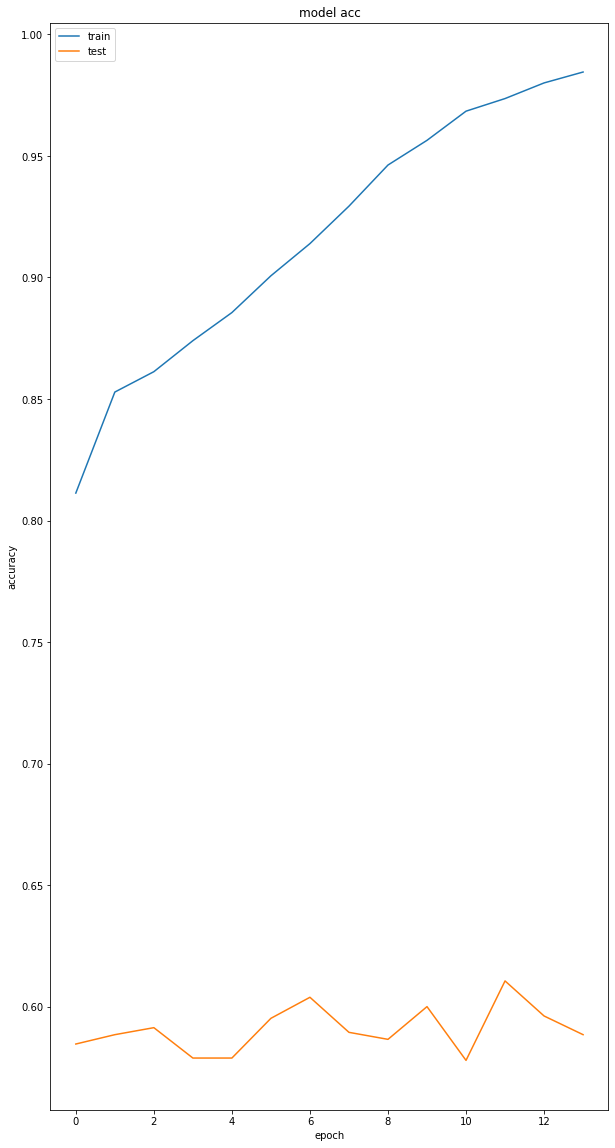

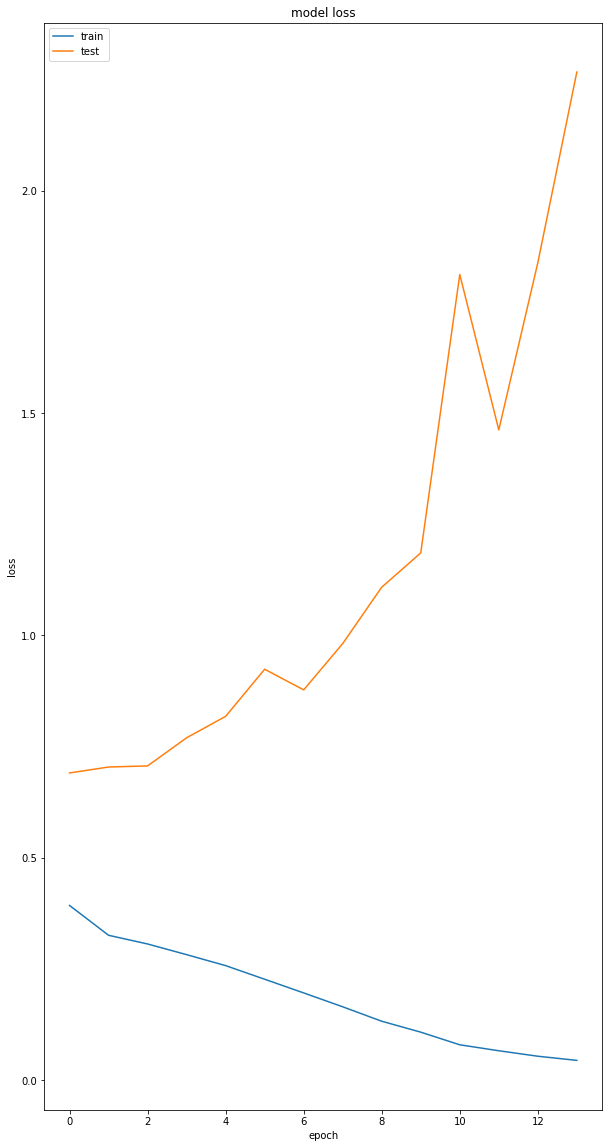

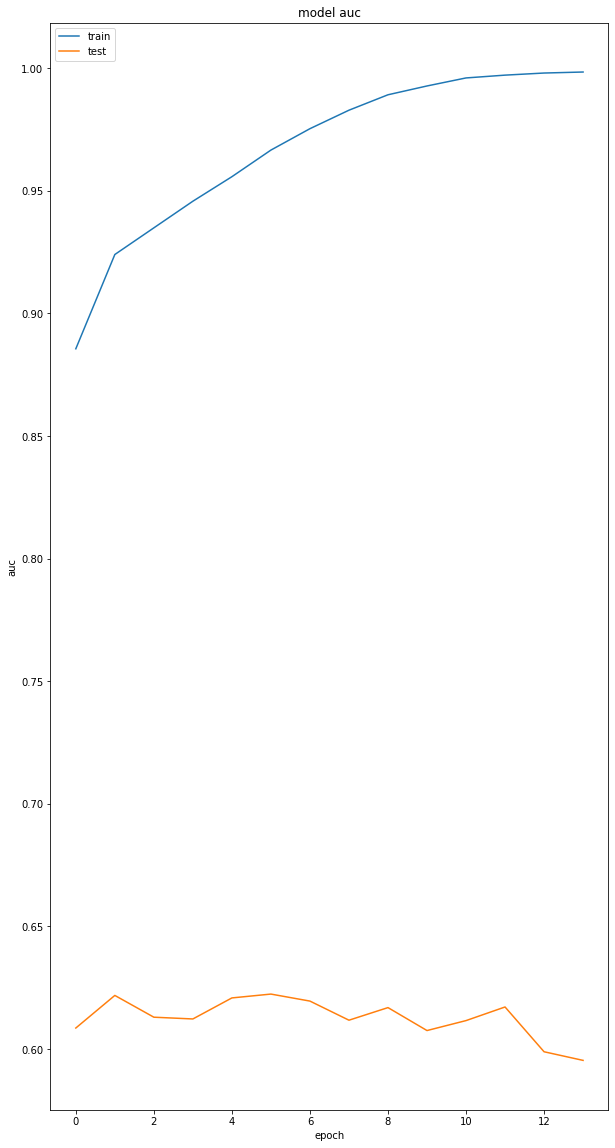

In [ ]:

import matplotlib.pyplot as plt
import numpy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# !unzip fb.zip

In [ ]:
input()

In [ ]:
%ls data

In [ ]:
import pandas as pd
labels = np.concatenate((labels, [-1]*1000))
data = {
      'sentence':  sentences,
      'label': labels
      }

df = pd.DataFrame (data, columns = ['sentence','label'])
df.to_csv('SVM_dataset.csv')

In [ ]:
from tensorflow.keras.models import save_model
save_model( model, '60%auroc.h5')